In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import folium
import folium.plugins
import logging
from eo_tools.util import explore_products, show_s2_color
from eo_tools.S2 import process_s2_tiles
from zipfile import ZipFile

from eodag import EODataAccessGateway

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
logging.basicConfig(level=logging.INFO)

# change your data directories
path_data = "/data"
path_s5p = f"{path_data}/S5P"
path_processed = f"{path_data}/res"

In [ ]:

# dag.discover_product_types()

## Select an area of interest

- Select a drawing tool (polygon, circle or rectangle)
- Draw the AOI on the map
- Click "Export" on the right to save the GeoJSON file

In [ ]:
map_select = folium.Map()
folium.plugins.Draw(
    export=True,
    draw_options={
        "polyline": False,
        "circlemarker": False,
        "marker": False,
    },
).add_to(map_select)
map_select

# Search

In [2]:
# load a geometry
# file_aoi = "../data/Bretagne_AOI.geojson"
file_aoi = "../data/Nevado-del-Ruiz.geojson"
shp = gpd.read_file(file_aoi).geometry[0]
search_criteria = {
    "productType": "S5P_L2_SO2",
    "start": "2024-02-04",
    "end": "2024-02-06",
    "geom": shp
}
results = dag.search_all(**search_criteria)

INFO:eodag.core:Searching product type 'S5P_L2_SO2' on provider: cop_dataspace
INFO:eodag.core:Iterate search over multiple pages: page #1
INFO:eodag.search.qssearch:Sending search request: http://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel5P/search.json?startDate=2024-02-04&completionDate=2024-02-06&geometry=POLYGON ((-75.4513 4.7997, -75.4513 4.9775, -75.1890 4.9775, -75.1890 4.7997, -75.4513 4.7997))&productType=L2__SO2___&maxRecords=1000&page=1&exactCount=1
INFO:eodag.core:Found 4 result(s) on provider 'cop_dataspace'


Getting unique dates to help with product exploration

In [ ]:
def get_unique_dates(results):
    import numpy as np

    dates = []
    for p in results:
        dates.append(p.properties["startTimeFromAscendingNode"])
    return np.unique(dates).tolist()

dates = get_unique_dates(results)
print(f"unique dates:")
print(", \n".join(dates))

# Visualize product footprints on a map

In [4]:
# show all results
# explore_products(results, shp)

# filter by date
results_filtered = results.filter_date("2024-02-04T18:00", "2024-02-04T19:00") 
explore_products(results_filtered, shp)

INFO:eodag.crunch.date:Finished filtering products. 1 resulting products


# Download

In [5]:
# re-run to get only links
dl = dag.download_all(results_filtered, outputs_prefix=path_s5p, extract=True, delete_archive=True)

INFO:eodag.core:Downloading 1 products


Downloaded products:   0%|          | 0/1 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

INFO:eodag.download.base:Download url: https://catalogue.dataspace.copernicus.eu/odata/v1/Products(3e64a246-dda9-4805-a2ea-f4b3ffc98f10)/$value
INFO:eodag.download.base:Product already downloaded: /data/S5P/S5P_NRTI_L2__SO2____20240204T181248_20240204T181748_32707_03_020601_20240204T185817.zip
INFO:eodag.download.base:Extraction cancelled, destination directory already exists and is not empty: /data/S5P/S5P_NRTI_L2__SO2____20240204T181248_20240204T181748_32707_03_020601_20240204T185817
INFO:eodag.product:Remote location of the product is still available through its 'remote_location' property: https://catalogue.dataspace.copernicus.eu/odata/v1/Products(3e64a246-dda9-4805-a2ea-f4b3ffc98f10)/$value


In [ ]:
dl

In [ ]:
# zip_s5p = ZipFile(dl[0])
# zip_s5p.extractall(path_s5p)
# s5p_dir = dl[0].replace(".zip", "")

In [7]:
ds.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:                                        (scanline: 357,
                                                    ground_pixel: 450, time: 1,
                                                    corner: 4, layer: 34)
Coordinates:
  * scanline                                       (scanline) float64 0.0 ......
  * ground_pixel                                   (ground_pixel) float64 0.0...
  * time                                           (time) datetime64[ns] 2024...
  * corner                                         (corner) float64 0.0 ... 3.0
  * layer                                          (layer) int32 0 1 2 ... 32 33
Data variables:
    latitude                                       (time, scanline, ground_pixel) float32 ...
    longitude                                      (time, scanline, ground_pixel) float32 ...
    delta_time                                     (time, scanline, ground_pixel) datetime64[ns] ...
    time_u

In [6]:
import xarray as xr
import rioxarray
ds = xr.load_dataset(dl[0], group="PRODUCT")
# rioxarray.open_rasterio(dl[0])
# ds.rio.to_raster(f"{path_s5p}/toto.tif")

In [10]:
darr = ds.sulfurdioxide_total_vertical_column.values.ravel()
lon = ds.longitude.values.ravel()
lat = ds.latitude.values.ravel()

In [15]:
import numpy as np
minlon, maxlon = lon.min(), lon.max()
minlat, maxlat = lat.min(), lat.max()

x = np.linspace(minlon, minlat, 1000)
y = np.linspace(minlon, minlat, 500)

xx, yy = np.meshgrid(x, y)

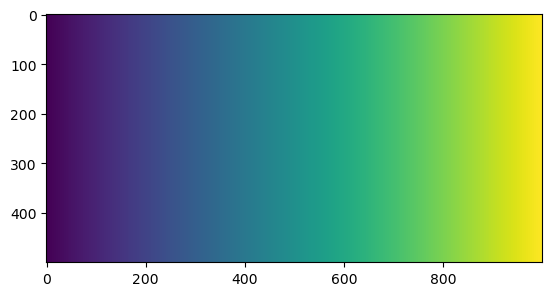

In [16]:
import matplotlib.pyplot as plt
plt.imshow(xx)

In [112]:
ds["sulfurdioxide_total_vertical_column"].values[0,:,:]

array([[            nan, -2.26686010e-04, -2.47482676e-04, ...,
        -6.46862900e-05,  3.81750637e-04,  7.23176490e-05],
       [            nan,  5.85821748e-04,  7.02739402e-04, ...,
         1.86848367e-04,  2.46583746e-04,  3.40507599e-04],
       [            nan, -4.91547216e-05, -3.47748610e-05, ...,
        -1.02035709e-04,  3.94188392e-05, -2.63852300e-04],
       ...,
       [            nan, -1.70929328e-04, -1.32922942e-04, ...,
         2.81536486e-04,  4.31523047e-04,  1.55312926e-04],
       [            nan, -1.60405983e-03, -5.05701930e-04, ...,
         6.84155326e-04,  6.05910027e-04,  9.09777300e-04],
       [            nan, -2.00314345e-04, -1.09817390e-03, ...,
         1.00489684e-04,  1.52461769e-04,  7.07483501e-04]], dtype=float32)

In [111]:
da = xr.DataArray(
    data=ds["sulfurdioxide_total_vertical_column"].data[0],
    dims=["x", "y"],
    # coords = dict(
      # x = (["x","y"], ds["longitude"].data[0]),
      # y = (["x","y"], ds["latitude"].data[0])
    # )
    # coords={"x": ds["scanline"], "y": ds["ground_pixel"], "latitude": ds["latitude"], "longitude": ds["longitude"]}
    # coords = dict(
    #   longitude = (["longitude","latitude"], ds["longitude"].data[0]),
    #   latitude = (["longitude","latitude"], ds["latitude"].data[0])
    # )
    coords={"x": ds["longitude"].values[0], "y": ds["latitude"].values[0]}
)

# da = xr.DataArray(no2,
#                   coords={'y': y, 'x': x},
#                   dims=('y', 'x'),
#                   attrs={'crs': 'EPSG:4326'})

MissingDimensionsError: cannot set variable 'x' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

In [68]:
da = ds["sulfurdioxide_total_vertical_column"]

In [109]:
ds.latitude.values.shape

(1, 357, 450)

In [105]:
da.rio.write_crs("epsg:4326", inplace=True)
da_re = da.rio.reproject("epsg:4326")
da_re.rio.to_raster(f"{path_s5p}/toto.tif")

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
da = ds["sulfurdioxide_total_vertical_column"]

In [ ]:

da.plot(vmin=0, vmax=0.01)